# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime
from scipy.stats import linregress
import json

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [18]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

640

In [19]:
#create a dataframe to store city info
df_cities = pd.DataFrame({'City': cities})

#add columns to store information from openweathermap api
df_cities['Country'] = ''
df_cities['Latitude'] = ''
df_cities['Longitude'] = ''
df_cities['Max Temperature (F)'] = ''
df_cities['Humidity (%)'] = ''
df_cities['Cloudiness (%)'] = ''
df_cities['Wind Speed (mph)'] = ''
df_cities['Date'] = ''

df_cities.head()

,City,Country,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),Date
0,new norfolk,,,,,,,,
1,busselton,,,,,,,,
2,mataura,,,,,,,,
3,prince rupert,,,,,,,,
4,kapaa,,,,,,,,


---
## Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [20]:

url = "http://api.openweathermap.org/data/2.5/weather"

params = {
    "mode": "json",
    "appid": weather_api_key,
    "units": "Imperial"
}

# keeps count of those cities whose weather information is successfully obtained
city_count = 0

# initializing # of variables
api_call_count = 1 # count for API calls made to OpenWeatherAPI, max 60 counts allowed for free API calls
sets = 1 # to track set of calls each minute
start_time = time.time() # get current time

print("Beginning Data Retrieval")     
print("-----------------------------")

#loop through all rows and fill in values for blank columns in dataframe
for index,row in df_cities.iterrows():
    city_name = row['City']
    
    params['q'] = str(city_name)

    response = requests.get(url, params=params)
        
    response_json = response.json()

    # Check that city has entry on OpenWeatherMap.
    if response_json['cod'] == 200: #check if response was success
        df_cities.loc[index,'Country'] = response_json['sys']['country']
        df_cities.loc[index,'Latitude'] = response_json['coord']['lat']
        df_cities.loc[index,'Longitude'] = response_json['coord']['lon']
        df_cities.loc[index,'Max Temperature (F)'] = response_json['main']['temp_max']
        df_cities.loc[index,'Humidity (%)'] = response_json['main']['humidity']
        df_cities.loc[index,'Cloudiness (%)'] = response_json['clouds']['all']
        df_cities.loc[index,'Wind Speed (mph)'] = response_json['wind']['speed']
        df_cities.loc[index,'Date'] = datetime.fromtimestamp(int(response_json['dt'])).strftime('%Y/%m/%d')
        
        #print log for each city
        print(f'Processing Record {api_call_count} of Set {sets} | {city_name}' )
        
        city_count = city_count + 1 # only increment if you get all the weather information

    else:
#        if response is not success, say 404:
        print("City not found. Skipping...")
    
    api_call_count += 1
    
    # can go upto 60 calls per minute since we are tracking time taken to make 60 calls and sleeping for remaining time of the minute
    if api_call_count == 61:
        end_time = time.time()
        api_call_count = 1
        sets +=1
        time.sleep(60-(end_time - start_time))
        start_time = time.time()

        
print("-----------------------------")
print("Data Retrieval Complete")      
print("-----------------------------")
print(f"Processing successfully completed. Retrieved weather information for {city_count} cities")

Beginning Data Retrieval
-----------------------------
Processing Record 1 of Set 1 | new norfolk
Processing Record 2 of Set 1 | busselton
Processing Record 3 of Set 1 | mataura
Processing Record 4 of Set 1 | prince rupert
Processing Record 5 of Set 1 | kapaa
Processing Record 6 of Set 1 | butaritari
Processing Record 7 of Set 1 | punta arenas
Processing Record 8 of Set 1 | rikitea
Processing Record 9 of Set 1 | basco
City not found. Skipping...
Processing Record 11 of Set 1 | albany
Processing Record 12 of Set 1 | kanchanaburi
Processing Record 13 of Set 1 | baracoa
Processing Record 14 of Set 1 | provideniya
Processing Record 15 of Set 1 | nishihara
Processing Record 16 of Set 1 | jamestown
City not found. Skipping...
Processing Record 18 of Set 1 | huarmey
Processing Record 19 of Set 1 | san cristobal
Processing Record 20 of Set 1 | key west
Processing Record 21 of Set 1 | morro bay
Processing Record 22 of Set 1 | bhusawal
Processing Record 23 of Set 1 | lavrentiya
Processing Record

---
## Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [47]:
#drop any record that has NaN
df_cities = df_cities.dropna(how='any')

#change data recieved from openweathermap api to numeric
df_cities['Latitude'] = pd.to_numeric(df_cities['Latitude'])
df_cities['Longitude'] = pd.to_numeric(df_cities['Longitude'])
df_cities['Max Temperature (F)'] = pd.to_numeric(df_cities['Max Temperature (F)'])
df_cities['Humidity (%)'] = pd.to_numeric(df_cities['Humidity (%)'])
df_cities['Cloudiness (%)'] = pd.to_numeric(df_cities['Cloudiness (%)'])
df_cities['Wind Speed (mph)'] = pd.to_numeric(df_cities['Wind Speed (mph)'])

#get today's date for plot title
today = datetime.now().strftime("%m/%d/%Y")

# save dataframe to csv
df_cities.to_csv('./output_data/WeatherPy.csv')

In [48]:
df_cities.head()

,City,Country,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),Date
0,new norfolk,AU,-42.78,147.06,73.99,40.0,75.0,19.46,2020/01/24
1,busselton,AU,-33.65,115.33,88.00,28.0,0.0,5.37,2020/01/24
2,mataura,NZ,-46.19,168.86,66.99,62.0,72.0,8.01,2020/01/24
3,prince rupert,CA,54.32,-130.32,44.60,93.0,90.0,4.70,2020/01/24
4,kapaa,US,22.08,-159.32,78.80,73.0,90.0,12.75,2020/01/24


In [49]:
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 587 entries, 0 to 639
Data columns (total 9 columns):
City                   587 non-null object
Country                587 non-null object
Latitude               587 non-null float64
Longitude              587 non-null float64
Max Temperature (F)    587 non-null float64
Humidity (%)           587 non-null float64
Cloudiness (%)         587 non-null float64
Wind Speed (mph)       587 non-null float64
Date                   587 non-null object
dtypes: float64(6), object(3)
memory usage: 45.9+ KB


---
## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

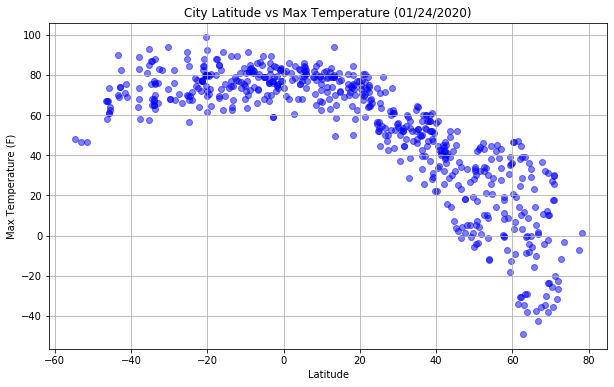

In [24]:
# Plot - Latitude vs. Max Temperature
plt.figure(figsize=(10,6))
plt.scatter(df_cities["Latitude"], df_cities["Max Temperature (F)"], color='b', alpha=0.5)
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title(f'City Latitude vs Max Temperature ({today})')
plt.savefig("./output_data/LatVsMaxTemp.png")
plt.show()

##### Observed Trend 1:
Temparature gets warmer as we get closer to equator (lat=0).

Also, noticed that eventhough random.uniform function was used to select cities, the report above shows the data is more skewed towards northern hemisphere - fact that there are lot of cities between lat 60 to 80 whereas no city selected below lat -60.  This is because there are more habitable land in the northern hemisphere in those region than in southern hemisphere.  Southernmost tip of Chile is about -55 and barely any cities across that latitude anywhere.  

#### Observed Trend 2:
Notice temparature drops lot colder as we go up the northern hemisphere (lat > 20), whereas for the same lat (< 20) on southern hemisphere it is still warmer.  This makes sense as the weather was checked on Jan 24 when it is Winter in Northern hemisphere and Summer in Southern hemisphere.

#### Latitude vs. Humidity Plot

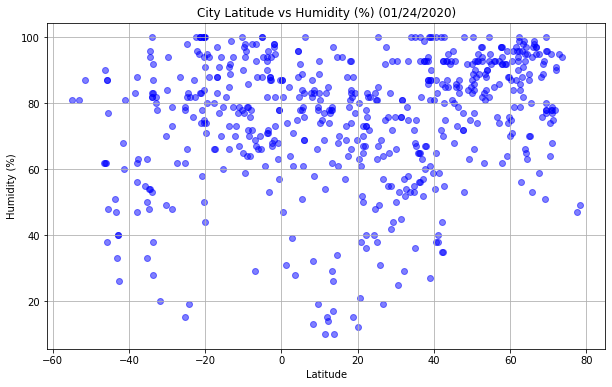

In [25]:
# Plot - Latitude vs. Humidity
plt.figure(figsize=(10,6))
plt.scatter(df_cities["Latitude"], df_cities["Humidity (%)"], color='b', alpha=0.5)
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title(f'City Latitude vs Humidity (%) ({today})')
plt.savefig("./output_data/LatVsHumidity.png")
plt.show()

#### Latitude vs. Cloudiness Plot

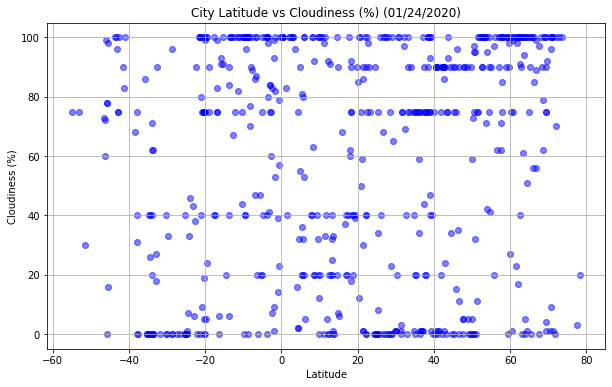

In [26]:
# Plot - Latitude vs. Cloudiness
plt.figure(figsize=(10,6))
plt.scatter(df_cities["Latitude"], df_cities["Cloudiness (%)"], color='b', alpha=0.5)
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title(f'City Latitude vs Cloudiness (%) ({today})')
plt.savefig("./output_data/LatVsCloudiness.png")
plt.show()

#### Latitude vs. Wind Speed Plot

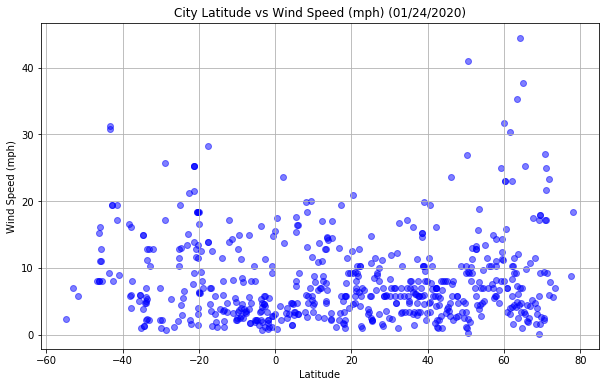

In [27]:
# Plot - Latitude vs. Wind Speed
plt.figure(figsize=(10,6))
plt.scatter(df_cities["Latitude"], df_cities["Wind Speed (mph)"], color='b', alpha=0.5)
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title(f'City Latitude vs Wind Speed (mph) ({today})')
plt.savefig("./output_data/LatVsWindSpeed.png")
plt.show()

---
## Linear Regression

In [28]:
# OPTIONAL: Create a function to create Linear Regression plots


In [29]:
# Create Northern and Southern Hemisphere DataFrames
north_hemisphere_df = df_cities.loc[df_cities["Latitude"] > 0, :]
south_hemisphere_df = df_cities.loc[df_cities["Latitude"] < 0, :]

#### Northern Hemisphere - Max Temp vs. Latitude Linear Regression

Regression line equation is: y = -1.33x + 91.8
The r-squared is: 0.7439678443529056


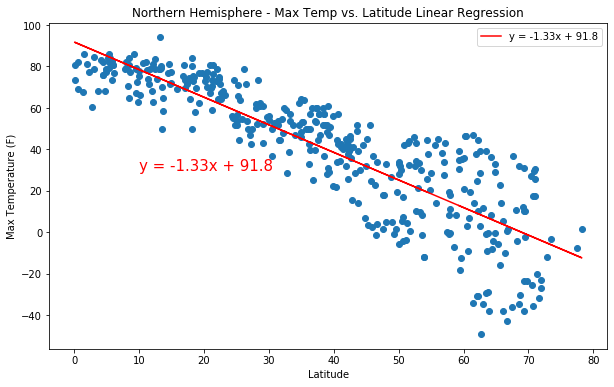

In [30]:
x_values = north_hemisphere_df["Latitude"]
y_values = north_hemisphere_df["Max Temperature (F)"]

plt.figure(figsize=(10,6))
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# write the equation text in to a variable
regress_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"Regression line equation is: {regress_eq}")

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-", label=regress_eq)

plt.annotate(regress_eq,(10,30),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title('Northern Hemisphere - Max Temp vs. Latitude Linear Regression')
print(f"The r-squared is: {rvalue**2}")
plt.legend()
plt.savefig("./output_data/LinregressNorthLatVsMaxTemp.png")
plt.show()

#### Southern Hemisphere - Max Temp vs. Latitude Linear Regression

Regression line equation is: y = 0.22x + 79.95
The r-squared is: 0.11746189109370596


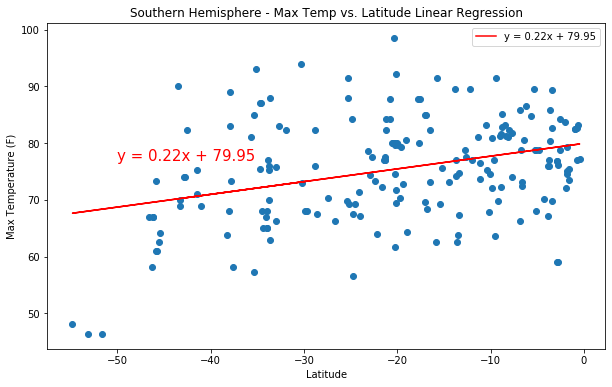

In [34]:
x_values = south_hemisphere_df["Latitude"]
y_values = south_hemisphere_df["Max Temperature (F)"]

plt.figure(figsize=(10,6))
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# write the equation text in to a variable
regress_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"Regression line equation is: {regress_eq}")

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-", label=regress_eq)

plt.annotate(regress_eq,(-50,77),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title('Southern Hemisphere - Max Temp vs. Latitude Linear Regression')
print(f"The r-squared is: {rvalue**2}")
plt.legend()
plt.savefig("./output_data/LinregressSouthLatVsMaxTemp.png")
plt.show()

#### Observed Trend 3:
From the two regression plots above, notice that Northern Hemisphere has a negative correlation i.e. temp dropping as the latitude increases.  As mentioned before, it is currently winter in the north.
The Southern Hemisphere plot is a positive correlation i.e. temp gets warmer as we get closer to equator since it is summer in the south.

#### Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

Regression line equation is: y = 0.34x + 62.48
The r-squared is: 0.12169672141839923


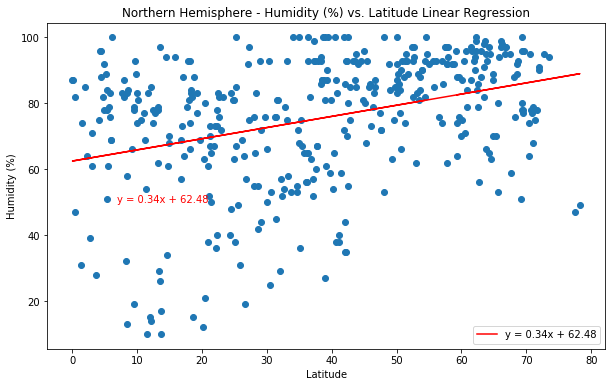

In [35]:
x_values = north_hemisphere_df["Latitude"]
y_values = north_hemisphere_df["Humidity (%)"]

plt.figure(figsize=(10,6))
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# write the equation text in to a variable
regress_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"Regression line equation is: {regress_eq}")

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-", label=regress_eq)

plt.annotate(regress_eq,(7,50),fontsize=10,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title('Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression')
print(f"The r-squared is: {rvalue**2}")
plt.legend()
plt.savefig("./output_data/LinregressNorthLatVsHumidity.png")
plt.show()

#### Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

Regression line equation is: y = 0.43x + 84.53
The r-squared is: 0.10034467197864762


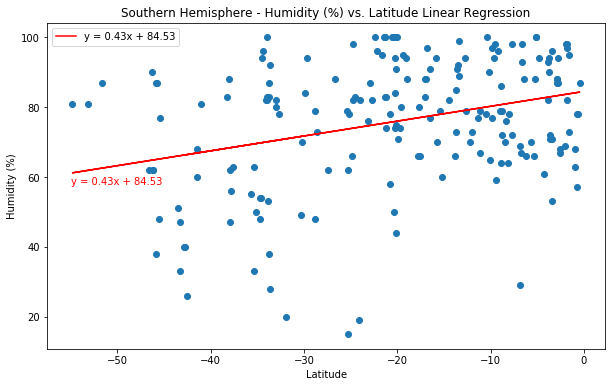

In [38]:
x_values = south_hemisphere_df["Latitude"]
y_values = south_hemisphere_df["Humidity (%)"]

plt.figure(figsize=(10,6))
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# write the equation text in to a variable
regress_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"Regression line equation is: {regress_eq}")

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-", label=regress_eq)

plt.annotate(regress_eq,(-55,58),fontsize=10,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title('Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression')
print(f"The r-squared is: {rvalue**2}")
plt.legend()
plt.savefig("./output_data/LinregressSouthLatVsHumidity.png")
plt.show()

#### Observed Trend 4:
Humidity is higher as we get closer to equator.

#### Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

Regression line equation is: y = 0.36x + 45.22
The r-squared is: 0.036485420908057585


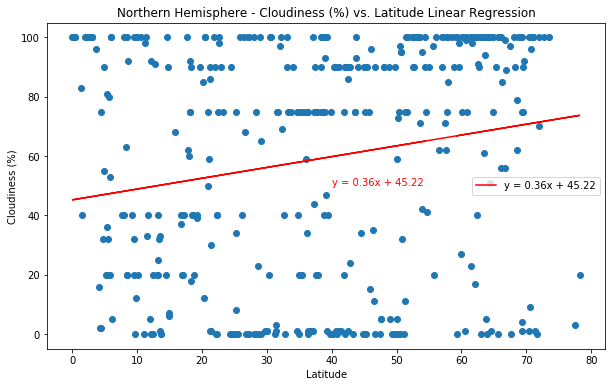

In [39]:
x_values = north_hemisphere_df["Latitude"]
y_values = north_hemisphere_df["Cloudiness (%)"]

plt.figure(figsize=(10,6))
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# write the equation text in to a variable
regress_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"Regression line equation is: {regress_eq}")

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-", label=regress_eq)

plt.annotate(regress_eq,(40,50),fontsize=10,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title('Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression')
print(f"The r-squared is: {rvalue**2}")
plt.legend()
plt.savefig("./output_data/LinregressNorthLatVsCloudiness.png")
plt.show()

#### Observed Trend 5:
No discernable relationship between Latitude and Cloudiness.

#### Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

Regression line equation is: y = 0.58x + 68.24
The r-squared is: 0.04238047610718379


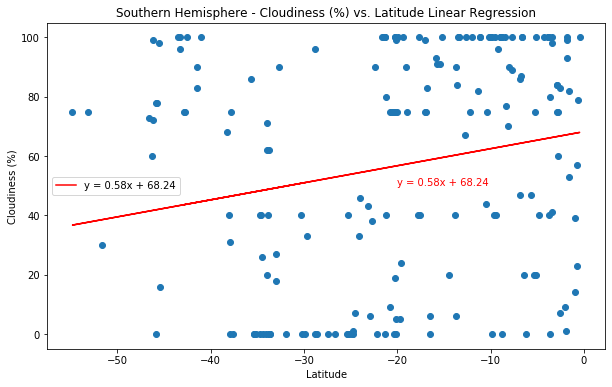

In [41]:
x_values = south_hemisphere_df["Latitude"]
y_values = south_hemisphere_df["Cloudiness (%)"]

plt.figure(figsize=(10,6))
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# write the equation text in to a variable
regress_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"Regression line equation is: {regress_eq}")

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-", label=regress_eq)

plt.annotate(regress_eq,(-20,50),fontsize=10,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title('Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression')
print(f"The r-squared is: {rvalue**2}")
plt.legend()
plt.savefig("./output_data/LinregressSouthLatVsCloudiness.png")
plt.show()

#### Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

Regression line equation is: y = 0.05x + 6.34
The r-squared is: 0.023483953744798346


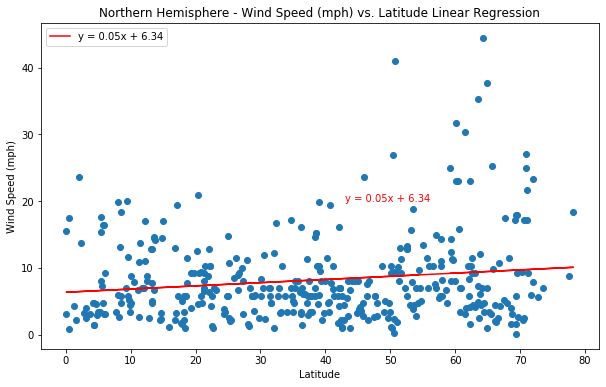

In [43]:
x_values = north_hemisphere_df["Latitude"]
y_values = north_hemisphere_df["Wind Speed (mph)"]

plt.figure(figsize=(10,6))
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# write the equation text in to a variable
regress_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"Regression line equation is: {regress_eq}")

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-", label=regress_eq)

plt.annotate(regress_eq,(43,20),fontsize=10,color="red")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title('Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression')
print(f"The r-squared is: {rvalue**2}")
plt.legend()
plt.savefig("./output_data/LinregressNorthLatVsWindSpeed.png")
plt.show()

#### Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

Regression line equation is: y = -0.15x + 5.18
The r-squared is: 0.09519018298242249


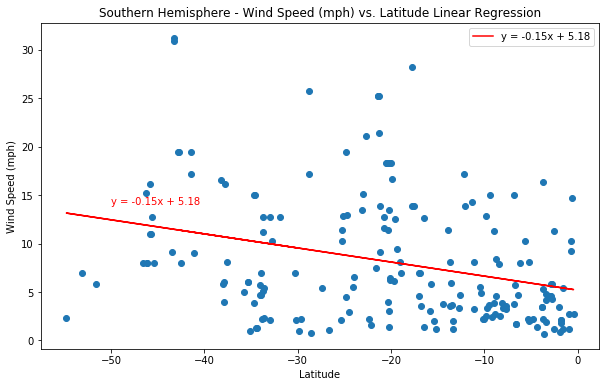

In [46]:
x_values = south_hemisphere_df["Latitude"]
y_values = south_hemisphere_df["Wind Speed (mph)"]

plt.figure(figsize=(10,6))
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# write the equation text in to a variable
regress_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"Regression line equation is: {regress_eq}")

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-", label=regress_eq)

plt.annotate(regress_eq,(-50,14),fontsize=10,color="red")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title('Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression')
print(f"The r-squared is: {rvalue**2}")
plt.legend()
plt.savefig("./output_data/LinregressSouthLatVsWindSpeed.png")
plt.show()